# Part A - Van Gogh Painting Classifier

## Deep Learning Project - Tel Aviv University

This notebook implements a binary classifier to identify Van Gogh paintings using transfer learning with VGG19.

### Overview:
1. **Load Data**: Read pre-prepared CSV file with image paths and labels
2. **Split Dataset**: 70% train, 15% validation, 15% test
3. **Data Augmentation**: Apply transforms for training robustness
4. **Model**: VGG19 pre-trained on ImageNet, fine-tuned for binary classification
5. **Hyperparameter Tuning**: Use Optuna to find best parameters
6. **Training**: Train final model with best hyperparameters
7. **Evaluation**: Test set metrics and visualizations

### Requirements:
- Google Colab with GPU runtime
- `post_impressionism_data.csv` file (created by Get_Post_Impressionism_Data.ipynb)
- Weights & Biases account for experiment tracking

---


## 1. Environment Setup


In [1]:
# Check if running on Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running on Google Colab")
else:
    print("Running locally")


Running locally


In [2]:
# Install required packages: optuna (hyperparameter tuning), wandb (experiment tracking)
%pip install -q optuna wandb

Note: you may need to restart the kernel to use updated packages.


## 2. Import Libraries


In [4]:
# Import libraries
import os
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)

# Hyperparameter tuning and logging
import optuna
import wandb

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Hardware Benchmark Setup (Required by instructions - Page 7)
print("="*60)
print("HARDWARE BENCHMARK INFORMATION")
print("="*60)
print(f"Python Version: {platform.python_version()}")
print(f"Machine Name: {platform.node()}")
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Model: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory Total: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"GPU Memory Cached: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
print(f"PyTorch version: {torch.__version__}")
print("="*60)


HARDWARE BENCHMARK INFORMATION
Python Version: 3.11.13
Machine Name: 16d494a75f78
GPU Available: True
GPU Model: Tesla T4
GPU Memory Total: 14.74 GB
GPU Memory Allocated: 0.00 GB
GPU Memory Cached: 0.00 GB
PyTorch version: 2.6.0+cu124


In [5]:
# Setup device (GPU/CPU) - GPU is much faster for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == 'cpu':
    print("WARNING: Running on CPU. Enable GPU in Colab: Runtime -> Change runtime type -> GPU")


Using device: cuda


In [6]:
# CPU vs GPU Benchmark (Required by instruction 1.34)
# Measure time for 20 forward+backward iterations on both CPU and GPU
import time

print("="*60)
print("CPU vs GPU BENCHMARK")
print("="*60)
print(f"Machine name: {platform.node()}")
if torch.cuda.is_available():
    print(f"GPU model: {torch.cuda.get_device_name(0)}")
print("="*60)

# Create a dummy model for benchmarking
dummy_model = nn.Sequential(
    nn.Conv2d(3, 64, 3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(64, 2)
)
dummy_input = torch.randn(8, 3, 224, 224)
criterion = nn.CrossEntropyLoss()
dummy_labels = torch.randint(0, 2, (8,))

# CPU Benchmark
print("\nRunning CPU benchmark (20 iterations)...")
cpu_model = dummy_model.to('cpu')
cpu_input = dummy_input.to('cpu')
cpu_labels = dummy_labels.to('cpu')
cpu_optimizer = torch.optim.Adam(cpu_model.parameters(), lr=0.001)

start_time = time.time()
for _ in range(20):
    cpu_optimizer.zero_grad()
    outputs = cpu_model(cpu_input)
    loss = criterion(outputs, cpu_labels)
    loss.backward()
    cpu_optimizer.step()
cpu_time = time.time() - start_time

print(f"CPU time: {cpu_time:.4f} seconds ({cpu_time/20*1000:.2f} ms per iteration)")

# GPU Benchmark (if available)
if torch.cuda.is_available():
    # Print machine name and GPU model before results (for documentation)
    print(f"\nMachine Name: {platform.node()}")
    print(f"GPU Model: {torch.cuda.get_device_name(0)}")
    print("\nRunning GPU benchmark (20 iterations)...")
    gpu_model = dummy_model.to('cuda')
    gpu_input = dummy_input.to('cuda')
    gpu_labels = dummy_labels.to('cuda')
    gpu_optimizer = torch.optim.Adam(gpu_model.parameters(), lr=0.001)
    
    # Warmup
    for _ in range(5):
        gpu_optimizer.zero_grad()
        outputs = gpu_model(gpu_input)
        loss = criterion(outputs, gpu_labels)
        loss.backward()
        gpu_optimizer.step()
    torch.cuda.synchronize()
    
    start_time = time.time()
    for _ in range(20):
        gpu_optimizer.zero_grad()
        outputs = gpu_model(gpu_input)
        loss = criterion(outputs, gpu_labels)
        loss.backward()
        gpu_optimizer.step()
    torch.cuda.synchronize()
    gpu_time = time.time() - start_time
    
    print(f"GPU time: {gpu_time:.4f} seconds ({gpu_time/20*1000:.2f} ms per iteration)")
    print(f"\nSpeedup: {cpu_time/gpu_time:.2f}x faster on GPU")
else:
    print("\nGPU not available, skipping GPU benchmark")

print("="*60)

CPU vs GPU BENCHMARK
Machine name: 16d494a75f78
GPU model: Tesla T4

Running CPU benchmark (20 iterations)...
CPU time: 6.5276 seconds (326.38 ms per iteration)

Machine Name: 16d494a75f78
GPU Model: Tesla T4

Running GPU benchmark (20 iterations)...
GPU time: 0.1471 seconds (7.36 ms per iteration)

Speedup: 44.37x faster on GPU


In [7]:
# Login to Weights & Biases for experiment tracking
wandb.login(key="16d1bc863b28f81253ac0ee253b453393791a7e1")
print("Logged in to Weights & Biases")


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: avitalkras (avitalkras-tel-aviv-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Logged in to Weights & Biases


## 3. Data Preparation


In [10]:
# Scan Post_Impressionism directory and create metadata CSV
import os
import pandas as pd

# Find Post_Impressionism directory (works in both Kaggle and Colab)
possible_dirs = [
    "/kaggle/input/Post_Impressionism",  # Kaggle
    "/content/data/Post_Impressionism",          # Colab
    "/content/Post_Impressionism",               # Colab alternative
    "/content/wikiart/Post_Impressionism",       # Colab alternative
]

base_dir = None
for dir_path in possible_dirs:
    if os.path.exists(dir_path):
        base_dir = dir_path
        break

if base_dir is None:
    raise FileNotFoundError(
        f"Post_Impressionism directory not found!\n"
        f"   Checked: {possible_dirs}\n"
        f"   Please download images to one of these locations."
    )

print(f"Found images in: {base_dir}")

# Scan directory and create DataFrame (like Nir)
records = []
for fname in os.listdir(base_dir):
    if not fname.lower().endswith((".jpg", ".png")):
        continue
    
    artist = fname.split("_")[0]  # Extract artist name from filename
    
    records.append({
        "filepath": os.path.join(base_dir, fname),
        "filename": fname,
        "artist": artist,
        "is_van_gogh": 1 if "van-gogh" in artist.lower() else 0
    })

df = pd.DataFrame(records)

# Save metadata to CSV
csv_output_path = "/kaggle/working/post_impressionism_data.csv" if os.path.exists("/kaggle") else ("/content/post_impressionism_data.csv" if IN_COLAB else "post_impressionism_data.csv")
df.to_csv(csv_output_path, index=False)
print(f"Saved metadata CSV: {csv_output_path}")

print(f"\nLoaded: {len(df)} images")
print(f"  Van Gogh: {df['is_van_gogh'].sum()}")
print(f"  Other: {len(df) - df['is_van_gogh'].sum()}")


Found images in: /kaggle/input/Post_Impressionism
Saved metadata CSV: /kaggle/working/post_impressionism_data.csv

Loaded: 6450 images
  Van Gogh: 1005
  Other: 5445


In [11]:
# Split dataset: 70% train, 15% validation, 15% test (stratified to maintain class balance)
train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df["is_van_gogh"], random_state=SEED
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["is_van_gogh"], random_state=SEED
)

print("Dataset splits:")
print(f"  Train: {len(train_df):5d} ({len(train_df)/len(df):.1%})")
print(f"  Val:   {len(val_df):5d} ({len(val_df)/len(df):.1%})")
print(f"  Test:  {len(test_df):5d} ({len(test_df)/len(df):.1%})")

print("\nClass distribution:")
print(f"  Train - Van Gogh: {train_df['is_van_gogh'].mean():.2%}")
print(f"  Val   - Van Gogh: {val_df['is_van_gogh'].mean():.2%}")
print(f"  Test  - Van Gogh: {test_df['is_van_gogh'].mean():.2%}")

# Save dataset splits for later use (so data preparation doesn't need to be rerun)
import pickle
import os
splits_save_path = 'dataset_splits.pkl'
with open(splits_save_path, 'wb') as f:
    pickle.dump({
        'train_df': train_df,
        'val_df': val_df,
        'test_df': test_df
    }, f)
print(f"\nDataset splits saved to '{splits_save_path}' (can skip data preparation next time)")


Dataset splits:
  Train:  4515 (70.0%)
  Val:     967 (15.0%)
  Test:    968 (15.0%)

Class distribution:
  Train - Van Gogh: 15.59%
  Val   - Van Gogh: 15.51%
  Test  - Van Gogh: 15.60%

Dataset splits saved to 'dataset_splits.pkl' (can skip data preparation next time)


## 4. Data Transforms & Dataset Class


In [12]:
# Define image transforms: resize to 224x224, normalize with ImageNet stats
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Training: data augmentation (random crop, flip, rotation, color jitter)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Evaluation: no augmentation (consistent evaluation)
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("Transforms defined")


Transforms defined


In [13]:
# Custom PyTorch Dataset class to load images from file paths
class VanGoghDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        # Filter out files that don't exist
        self.df = self.df[self.df['filepath'].apply(os.path.exists)].reset_index(drop=True)
        if len(self.df) < len(df):
            print(f"Warning: {len(df) - len(self.df)} files not found and removed")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try:
            image = Image.open(row["filepath"]).convert("RGB")
            label = row["is_van_gogh"]
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading {row['filepath']}: {e}")
            # Return a black image as fallback (shouldn't happen if we filtered)
            image = Image.new('RGB', (224, 224), color='black')
            label = row["is_van_gogh"]
            if self.transform:
                image = self.transform(image)
            return image, label

# Load dataset splits if they don't exist (in case data preparation wasn't run)
if 'train_df' not in globals() or 'val_df' not in globals() or 'test_df' not in globals():
    import pickle
    import os
    splits_save_path = 'dataset_splits.pkl'
    if os.path.exists(splits_save_path):
        print(f"Loading dataset splits from {splits_save_path}...")
        with open(splits_save_path, 'rb') as f:
            splits_data = pickle.load(f)
        train_df = splits_data['train_df']
        val_df = splits_data['val_df']
        test_df = splits_data['test_df']
        print(f"Loaded dataset splits: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")
    else:
        raise NameError(
            f"Dataset splits not found and '{splits_save_path}' doesn't exist!\n"
            "   Please run data preparation steps (Steps 3-4) first."
        )

# Create datasets
train_dataset = VanGoghDataset(train_df, transform=train_transform)
val_dataset = VanGoghDataset(val_df, transform=eval_transform)
test_dataset = VanGoghDataset(test_df, transform=eval_transform)

print(f"Datasets: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")


Datasets: Train=4515, Val=967, Test=968


## 5. Training Functions


In [14]:
# Training and evaluation functions
def train_one_epoch(model, loader, optimizer, criterion, device, max_grad_norm=1.0):
    """Train for one epoch: forward pass, compute loss, backward pass, update weights"""
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        # Gradient clipping for training stability
        if max_grad_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        total_loss += loss.item()
        # Note: batch_loss logging removed to avoid interfering with step=epoch alignment
        # Batch-level metrics are noisy and can cause step counter confusion
    return total_loss / len(loader)

@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    """Evaluate: forward pass only, compute loss and accuracy"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / len(loader), correct / total

print("Training functions defined")


Training functions defined


## 6. Hyperparameter Tuning with Optuna


In [15]:
# Create model: supports both VGG19 and AlexNet (project requirement)
# Smart Fine-tuning: When freeze_features=False, unfreeze only top layers to prevent overfitting
def create_model(model_name='VGG19', freeze_features=True, dropout=0.5):
    """
    Create model with binary classifier.
    Implements Smart Fine-tuning: When freeze_features=False, unfreezes only top layers.
    
    Args:
        model_name: 'VGG19' or 'AlexNet'
        freeze_features: If True, freeze feature extractor (only train classifier)
                        If False, unfreeze only top layers (Smart Fine-tuning)
        dropout: Dropout rate for classifier (0.0 to 0.7)
    """
    if model_name == 'VGG19':
        model = models.vgg19(weights='IMAGENET1K_V1')
        # First, freeze all feature layers by default
        for param in model.features.parameters():
            param.requires_grad = False
        
        # Smart Fine-tuning: If freeze_features=False, unfreeze only the last 8 layers
        if not freeze_features:
            # VGG19 features has 36 layers (0-35), unfreeze last 8 layers (28-35)
            # This corresponds to the top convolutional blocks
            for i in range(28, 36):
                for param in model.features[i].parameters():
                    param.requires_grad = True
        
        # Modify classifier: VGG19 classifier[6] is the last Linear layer
        # Classifier is always trainable
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(num_features, 2)  # Binary classification
        )
    elif model_name == 'AlexNet':
        model = models.alexnet(weights='IMAGENET1K_V1')
        # First, freeze all feature layers by default
        for param in model.features.parameters():
            param.requires_grad = False
        
        # Smart Fine-tuning: If freeze_features=False, unfreeze only the last 2 layers
        # AlexNet features has 12 layers (0-11), unfreeze last 2 layers (10-11)
        if not freeze_features:
            for i in range(10, 12):
                for param in model.features[i].parameters():
                    param.requires_grad = True
        
        # Modify classifier: AlexNet classifier[6] is the last Linear layer
        # Classifier is always trainable
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(num_features, 2)  # Binary classification
        )
    else:
        raise ValueError(f"Unknown model: {model_name}")
    
    return model.to(device)

def objective(trial):
    """Optuna objective: try hyperparameters, train model, return validation loss (minimize)"""
    # Optuna suggests hyperparameters
    model_name = trial.suggest_categorical("model_name", ["VGG19", "AlexNet"])  # Project requirement: both models
    lr = trial.suggest_float("lr", 1e-6, 1e-4, log=True)  # Lower LR range for fine-tuning stability
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "AdamW"])
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])  # Added 8 for smaller GPUs
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    momentum = trial.suggest_float("momentum", 0.8, 0.99) if optimizer_name == "SGD" else 0.0
    freeze_features = trial.suggest_categorical("freeze_features", [True, False])
    dropout = trial.suggest_float("dropout", 0.0, 0.7)  # Added dropout search

    # Create DataLoaders, model, optimizer
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)  # Like Nir
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    run = wandb.init(
        project="VanGogh_Classifier",
        name=f"trial_{trial.number}_{model_name}",
        config={"model_name": model_name, "lr": lr, "optimizer": optimizer_name, "batch_size": batch_size,
                "weight_decay": weight_decay, "momentum": momentum,
                "freeze_features": freeze_features, "dropout": dropout},
        reinit=True
    )
    
    # Define epoch as step metric to ensure X-axis starts at 0 for each trial
    run.define_metric("epoch", hidden=True)
    run.define_metric("train_loss", step_metric="epoch")
    run.define_metric("val_loss", step_metric="epoch")
    run.define_metric("val_acc", step_metric="epoch")
    run.define_metric("best_val_loss", step_metric="epoch")

    model = create_model(model_name=model_name, freeze_features=freeze_features, dropout=dropout)
    criterion = nn.CrossEntropyLoss()
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())

    if optimizer_name == "SGD":
        optimizer = torch.optim.SGD(trainable_params, lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_name == "AdamW":
        optimizer = torch.optim.AdamW(trainable_params, lr=lr, weight_decay=weight_decay)
    else:
        optimizer = torch.optim.Adam(trainable_params, lr=lr, weight_decay=weight_decay)

    # Train for a few epochs (quick evaluation for hyperparameter search)
    num_epochs = 3  # Reduced for faster trials (30-60 min total search time)
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = eval_one_epoch(model, val_loader, criterion, device)
        best_val_loss = min(best_val_loss, val_loss)
        wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss,
                   "val_acc": val_acc, "best_val_loss": best_val_loss}, step=epoch)
        trial.report(val_loss, epoch)
        if trial.should_prune():  # Stop bad trials early
            run.finish()
            raise optuna.exceptions.TrialPruned()
    run.finish()
    return best_val_loss

print("Optuna objective function defined (supports VGG19 and AlexNet, minimizes validation loss)")


Optuna objective function defined (supports VGG19 and AlexNet, minimizes validation loss)


In [16]:
# Run hyperparameter search with Optuna
# Project requirement: must take at least 30 minutes, max 60 minutes
# Objective: minimize validation loss
import optuna  # Ensure optuna is imported (in case cells run out of order)
import time

print("Starting hyperparameter search...")
print("="*60)
print("Objective: Minimize validation loss")

study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=2)
)

# Track start time
start_time = time.time()

# Run optimization (max 60 minutes - will stop at timeout)
study.optimize(objective, n_trials=10, timeout=3600, show_progress_bar=True)  # 10 trials for 30-60 min window

# Calculate elapsed time
elapsed_time = time.time() - start_time
elapsed_minutes = elapsed_time / 60

print("\n" + "="*60)
print("HYPERPARAMETER SEARCH COMPLETE!")
print("="*60)
print(f"\nTime taken: {elapsed_minutes:.2f} minutes ({elapsed_time:.0f} seconds)")
print(f"Completed trials: {len(study.trials)} / 10")

# Check project requirements
if elapsed_minutes < 30:
    print(f"\nWARNING: Search took only {elapsed_minutes:.2f} minutes!")
    print("   Project requires at least 30 minutes. Consider increasing n_trials.")
elif elapsed_minutes > 60:
    print(f"\nWARNING: Search took {elapsed_minutes:.2f} minutes (exceeded 60 min limit)")
else:
    print(f"\nTime requirement met: {elapsed_minutes:.2f} minutes (30-60 min range)")

print(f"\nBest validation loss: {study.best_value:.4f}")
print(f"\nBest hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Save study results for later use (so step 7 can run independently)
import pickle
study_save_path = 'optuna_study_results.pkl'
with open(study_save_path, 'wb') as f:
    pickle.dump({
        'best_params': study.best_params,
        'best_value': study.best_value,
        'n_trials': len(study.trials)
    }, f)
print(f"\nStudy results saved to '{study_save_path}' (can skip step 6 next time)")


[I 2026-01-05 14:59:40,139] A new study created in memory with name: no-name-66348bc6-5179-4df8-8008-0a31e695da5e


Starting hyperparameter search...
Objective: Minimize validation loss


  0%|          | 0/10 [00:00<?, ?it/s]

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth

  0%|          | 0.00/233M [00:00<?, ?B/s]
  4%|▎         | 8.25M/233M [00:00<00:02, 86.1MB/s]
 11%|█         | 25.2M/233M [00:00<00:01, 140MB/s] 
 18%|█▊        | 42.9M/233M [00:00<00:01, 160MB/s]
 28%|██▊       | 64.2M/233M [00:00<00:00, 185MB/s]
 36%|███▌      | 84.1M/233M [00:00<00:00, 193MB/s]
 45%|████▍     | 104M/233M [00:00<00:00, 197MB/s] 
 54%|█████▍    | 126M/233M [00:00<00:00, 208MB/s]
 63%|██████▎   | 148M/233M [00:00<00:00, 215MB/s]
 72%|███████▏  | 168M/233M [00:00<00:00, 213MB/s]
 81%|████████  | 188M/233M [00:01<00:00, 203MB/s]
 89%|████████▉ | 208M/233M [00:01<00:00, 194MB/s]
100%|██████████| 233M/233M [00:01<00:00, 192MB/s]


best_val_loss,█▄▁
epoch,▁▅█
train_loss,█▃▁
val_acc,▁▅█
val_loss,█▄▁
best_val_loss,0.33442
epoch,2
train_loss,0.37523
val_acc,0.8635
val_loss,0.33442


[I 2026-01-05 15:05:35,951] Trial 0 finished with value: 0.3344243383035064 and parameters: {'model_name': 'AlexNet', 'lr': 1.5757277395267007e-06, 'optimizer': 'AdamW', 'batch_size': 64, 'weight_decay': 1.0088327578344559e-05, 'freeze_features': True, 'dropout': 0.09244925019888198}. Best is trial 0 with value: 0.3344243383035064.


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth

  0%|          | 0.00/548M [00:00<?, ?B/s]
  1%|▏         | 7.50M/548M [00:00<00:07, 78.1MB/s]
  5%|▍         | 26.4M/548M [00:00<00:03, 148MB/s] 
  8%|▊         | 43.5M/548M [00:00<00:03, 162MB/s]
 12%|█▏        | 64.4M/548M [00:00<00:02, 184MB/s]
 15%|█▍        | 82.0M/548M [00:00<00:02, 183MB/s]
 18%|█▊        | 99.6M/548M [00:00<00:02, 181MB/s]
 22%|██▏       | 121M/548M [00:00<00:02, 195MB/s] 
 26%|██▌       | 140M/548M [00:00<00:02, 190MB/s]
 29%|██▉       | 162M/548M [00:00<00:02, 201MB/s]
 33%|███▎      | 183M/548M [00:01<00:01, 208MB/s]
 37%|███▋      | 205M/548M [00:01<00:01, 214MB/s]
 41%|████      | 225M/548M [00:01<00:01, 211MB/s]
 45%|████▌     | 247M/548M [00:01<00:01, 217MB/s]
 49%|████▉     | 269M/548M [00:01<00:01, 220MB/s]
 53%|█████▎    | 290M/548M [00:01<00:01, 216MB/s]
 57%|█████▋    | 311M/548M [00:01<00:01, 219MB/s]
 61%|██████    | 332

best_val_loss,█▁▁
epoch,▁▅█
train_loss,█▃▁
val_acc,▁▄█
val_loss,█▁▁
best_val_loss,0.16878
epoch,2
train_loss,0.13701
val_acc,0.94209
val_loss,0.17188


[I 2026-01-05 15:11:35,528] Trial 1 finished with value: 0.16878091411725168 and parameters: {'model_name': 'VGG19', 'lr': 2.4741268057743665e-05, 'optimizer': 'Adam', 'batch_size': 32, 'weight_decay': 0.00023697676322254448, 'freeze_features': False, 'dropout': 0.0916081432020224}. Best is trial 1 with value: 0.16878091411725168.


best_val_loss,█▄▁
epoch,▁▅█
train_loss,█▄▁
val_acc,▁▇█
val_loss,█▄▁
best_val_loss,0.1951
epoch,2
train_loss,0.22542
val_acc,0.92968
val_loss,0.1951


[I 2026-01-05 15:17:32,573] Trial 2 finished with value: 0.19510351397818135 and parameters: {'model_name': 'VGG19', 'lr': 5.546205244201523e-06, 'optimizer': 'Adam', 'batch_size': 32, 'weight_decay': 0.00013644665905446728, 'freeze_features': False, 'dropout': 0.2150352184416815}. Best is trial 1 with value: 0.16878091411725168.


best_val_loss,█▃▁
epoch,▁▅█
train_loss,█▂▁
val_acc,▁▇█
val_loss,█▃▁
best_val_loss,0.38895
epoch,2
train_loss,0.46806
val_acc,0.85212
val_loss,0.38895


[I 2026-01-05 15:23:09,533] Trial 3 pruned. 


best_val_loss,█▁▁
epoch,▁▅█
train_loss,█▃▁
val_acc,▁▆█
val_loss,█▁▁
best_val_loss,0.1966
epoch,2
train_loss,0.20649
val_acc,0.92658
val_loss,0.1966


[I 2026-01-05 15:28:40,118] Trial 4 pruned. 


best_val_loss,█▄▁
epoch,▁▅█
train_loss,█▃▁
val_acc,▁▅█
val_loss,█▄▁
best_val_loss,0.27147
epoch,2
train_loss,0.31089
val_acc,0.88108
val_loss,0.27147


[I 2026-01-05 15:34:41,843] Trial 5 pruned. 


best_val_loss,█▃▁
epoch,▁▅█
train_loss,█▃▁
val_acc,▁▇█
val_loss,█▃▁
best_val_loss,0.4643
epoch,2
train_loss,0.49601
val_acc,0.84385
val_loss,0.4643


[I 2026-01-05 15:40:34,874] Trial 6 pruned. 


best_val_loss,█▄▁
epoch,▁▅█
train_loss,█▅▁
val_acc,▁▄█
val_loss,█▄▁
best_val_loss,0.75746
epoch,2
train_loss,0.81757
val_acc,0.40434
val_loss,0.75746


[I 2026-01-05 15:46:34,499] Trial 7 pruned. 


best_val_loss,█▃▁
epoch,▁▅█
train_loss,█▂▁
val_acc,▁▇█
val_loss,█▃▁
best_val_loss,0.4178
epoch,2
train_loss,0.45306
val_acc,0.83557
val_loss,0.4178


[I 2026-01-05 15:52:13,815] Trial 8 pruned. 


best_val_loss,██▁
epoch,▁▅█
train_loss,█▃▁
val_acc,▄▁█
val_loss,▇█▁
best_val_loss,0.16137
epoch,2
train_loss,0.1636
val_acc,0.94002
val_loss,0.16137


[I 2026-01-05 15:57:45,676] Trial 9 finished with value: 0.16136761428788304 and parameters: {'model_name': 'AlexNet', 'lr': 7.386001288821499e-05, 'optimizer': 'Adam', 'batch_size': 64, 'weight_decay': 0.0010581858771386648, 'freeze_features': False, 'dropout': 0.21717283491300782}. Best is trial 9 with value: 0.16136761428788304.

HYPERPARAMETER SEARCH COMPLETE!

Time taken: 58.09 minutes (3486 seconds)
Completed trials: 10 / 10

Time requirement met: 58.09 minutes (30-60 min range)

Best validation loss: 0.1614

Best hyperparameters:
  model_name: AlexNet
  lr: 7.386001288821499e-05
  optimizer: Adam
  batch_size: 64
  weight_decay: 0.0010581858771386648
  freeze_features: False
  dropout: 0.21717283491300782

Study results saved to 'optuna_study_results.pkl' (can skip step 6 next time)


## 7. Train Final Model


In [17]:
# GPU Utilization Monitoring (Required for appendix)
# Run nvidia-smi to show GPU utilization and memory usage
import subprocess
import sys

print("="*60)
print("GPU UTILIZATION (nvidia-smi)")
print("="*60)
try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True, timeout=5)
    print(result.stdout)
    if result.stderr:
        print("Stderr:", result.stderr, file=sys.stderr)
except FileNotFoundError:
    print("nvidia-smi not found. This is expected if running on CPU or in some environments.")
    print("   GPU monitoring will be skipped.")
except subprocess.TimeoutExpired:
    print("nvidia-smi timed out.")
except Exception as e:
    print(f"Could not run nvidia-smi: {e}")
print("="*60)

GPU UTILIZATION (nvidia-smi)
Mon Jan  5 16:01:05 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P0             30W /   70W |    6157MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------

In [18]:
# Train final model with best hyperparameters
import pickle
import os

# Load best_params if study doesn't exist (in case step 6 wasn't run)
if 'study' not in globals() or study is None:
    study_save_path = 'optuna_study_results.pkl'
    if os.path.exists(study_save_path):
        print(f"Loading hyperparameters from {study_save_path}...")
        with open(study_save_path, 'rb') as f:
            study_data = pickle.load(f)
        best_params = study_data['best_params']
        print(f"Loaded hyperparameters (Best val loss: {study_data['best_value']:.4f})")
    else:
        raise NameError(
            f"'study' not found and '{study_save_path}' doesn't exist!\n"
            "   Please run Step 6 (Hyperparameter Tuning) first."
        )
else:
    best_params = study.best_params

print("\nTraining final model with best parameters:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

# Anti-overfitting improvements: increase dropout and weight decay
# Optuna found dropout ~0.29, but we have overfitting - increase to 0.4 for better regularization
original_dropout = best_params.get('dropout', 0.5)
improved_dropout = max(0.4, min(0.5, original_dropout + 0.1))  # Increase by 0.1, cap at 0.5
print(f"\nAnti-overfitting adjustments:")
print(f"   Dropout: {original_dropout:.4f} -> {improved_dropout:.4f}")

original_weight_decay = best_params.get('weight_decay', 1e-4)
improved_weight_decay = original_weight_decay * 1.25  # Increase by 25% for more regularization
print(f"   Weight decay: {original_weight_decay:.6f} → {improved_weight_decay:.6f}")

# Setup: DataLoaders, model, optimizer, scheduler
# Stability improvement: Manually set batch_size to 32 for final training (as per instructions)
# This reduces 'zigzag' effect in loss curves, regardless of Optuna suggestion
final_batch_size = 32  # Fixed batch size for stability (use 16 if memory is an issue)
print(f"\nBatch size: Optuna suggested {best_params.get('batch_size', 'N/A')}, using {final_batch_size} for stability")
final_train_loader = DataLoader(train_dataset, batch_size=final_batch_size, shuffle=True, num_workers=2)
final_val_loader = DataLoader(val_dataset, batch_size=final_batch_size, shuffle=False, num_workers=2)

trained_classifier = create_model(
    model_name=best_params.get('model_name', 'VGG19'),
    freeze_features=best_params.get('freeze_features', False),
    dropout=improved_dropout  # Use improved dropout
)
criterion = nn.CrossEntropyLoss()
trainable_params = filter(lambda p: p.requires_grad, trained_classifier.parameters())

if best_params['optimizer'] == "SGD":
    final_optimizer = torch.optim.SGD(trainable_params, lr=best_params['lr'],
                                       momentum=best_params.get('momentum', 0.9),
                                       weight_decay=improved_weight_decay)  # Use improved weight decay
elif best_params['optimizer'] == "AdamW":
    final_optimizer = torch.optim.AdamW(trainable_params, lr=best_params['lr'],
                                         weight_decay=improved_weight_decay)  # Use improved weight decay
else:
    final_optimizer = torch.optim.Adam(trainable_params, lr=best_params['lr'],
                                        weight_decay=improved_weight_decay)  # Use improved weight decay

# Improved learning rate scheduler: ReduceLROnPlateau with better settings
# Use min_lr to prevent LR from going too low, and smaller factor for smoother decay
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    final_optimizer, mode='max', factor=0.5, patience=2, 
    min_lr=1e-6 , threshold=0.001
)

# Training loop with early stopping
run = wandb.init(project="VanGogh_Classifier", name="trained_classifier_training",
                 config={**best_params, "training_type": "final", "gradient_clipping": True, "final_batch_size": final_batch_size}, reinit=True)

# Define epoch as step metric to ensure X-axis starts at 0 for final training
run.define_metric("epoch", hidden=True)
run.define_metric("train_loss", step_metric="epoch")
run.define_metric("val_loss", step_metric="epoch")
run.define_metric("val_acc", step_metric="epoch")
run.define_metric("lr", step_metric="epoch")

num_epochs = 15  # Reduced for time efficiency
best_val_acc = 0.0
best_model_state = None
patience = 5  # Increased early stopping patience (was 3) to allow more recovery
epochs_without_improvement = 0
train_losses, val_losses, val_accuracies = [], [], []

print("\nStarting training...")
print("="*60)
print("Improvements applied:")
print("   - Gradient clipping (max_norm=1.0) for stability")
print("   - Increased early stopping patience (3->5 epochs)")
print("   - Improved LR scheduler (min_lr, threshold)")
print("   - Increased dropout for better regularization")
print("   - Increased weight decay for more L2 regularization")
print("="*60)

for epoch in range(num_epochs):
    train_loss = train_one_epoch(trained_classifier, final_train_loader, final_optimizer, criterion, device, max_grad_norm=1.0)
    val_loss, val_acc = eval_one_epoch(trained_classifier, final_val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step(val_acc)
    current_lr = final_optimizer.param_groups[0]['lr']
    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss,
               "val_acc": val_acc, "lr": current_lr}, step=epoch)

    print(f"Epoch {epoch+1:02d}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | LR: {current_lr:.2e}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = {k: v.cpu().clone() for k, v in trained_classifier.state_dict().items()}
        epochs_without_improvement = 0
        print(f"  New best model! (Val Acc: {best_val_acc:.4f})")
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"\nEarly stopping after {epoch+1} epochs")
        break

trained_classifier.load_state_dict(best_model_state)
print(f"\n{'='*60}")
print(f"Training complete! Best validation accuracy: {best_val_acc:.4f}")

# Save model and training history for later use (so you don't need to retrain)
torch.save({
    'model_state_dict': best_model_state, 
    'best_params': best_params,
    'best_val_acc': best_val_acc,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies
}, 'best_vangogh_classifier.pth')
print("Model and training history saved to 'best_vangogh_classifier.pth'")

run.finish()



Training final model with best parameters:
  model_name: AlexNet
  lr: 7.386001288821499e-05
  optimizer: Adam
  batch_size: 64
  weight_decay: 0.0010581858771386648
  freeze_features: False
  dropout: 0.21717283491300782

Anti-overfitting adjustments:
   Dropout: 0.2172 -> 0.4000
   Weight decay: 0.001058 → 0.001323

Batch size: Optuna suggested 64, using 32 for stability



Starting training...
Improvements applied:
   - Gradient clipping (max_norm=1.0) for stability
   - Increased early stopping patience (3->5 epochs)
   - Improved LR scheduler (min_lr, threshold)
   - Increased dropout for better regularization
   - Increased weight decay for more L2 regularization
Epoch 01/15 | Train Loss: 0.3067 | Val Loss: 0.1980 | Val Acc: 0.9245 | LR: 7.39e-05
  New best model! (Val Acc: 0.9245)
Epoch 02/15 | Train Loss: 0.2251 | Val Loss: 0.1983 | Val Acc: 0.9255 | LR: 7.39e-05
  New best model! (Val Acc: 0.9255)
Epoch 03/15 | Train Loss: 0.2058 | Val Loss: 0.1831 | Val Acc: 0.9307 | LR: 7.39e-05
  New best model! (Val Acc: 0.9307)
Epoch 04/15 | Train Loss: 0.1869 | Val Loss: 0.2218 | Val Acc: 0.9059 | LR: 7.39e-05
Epoch 05/15 | Train Loss: 0.1826 | Val Loss: 0.1586 | Val Acc: 0.9390 | LR: 7.39e-05
  New best model! (Val Acc: 0.9390)
Epoch 06/15 | Train Loss: 0.1566 | Val Loss: 0.1758 | Val Acc: 0.9317 | LR: 7.39e-05
Epoch 07/15 | Train Loss: 0.1567 | Val Loss: 0

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
lr,███████▁▁▁▁▁▁▁▁
train_loss,█▅▅▄▄▃▃▃▂▂▁▁▂▁▁
val_acc,▄▄▅▁▆▅▅▆▇▇▇█▇▆█
val_loss,▆▆▄█▂▄▅▂▂▂▃▂▂▂▁
epoch,14
lr,4e-05
train_loss,0.07966
val_acc,0.94829
val_loss,0.14604


## 8. Visualizations


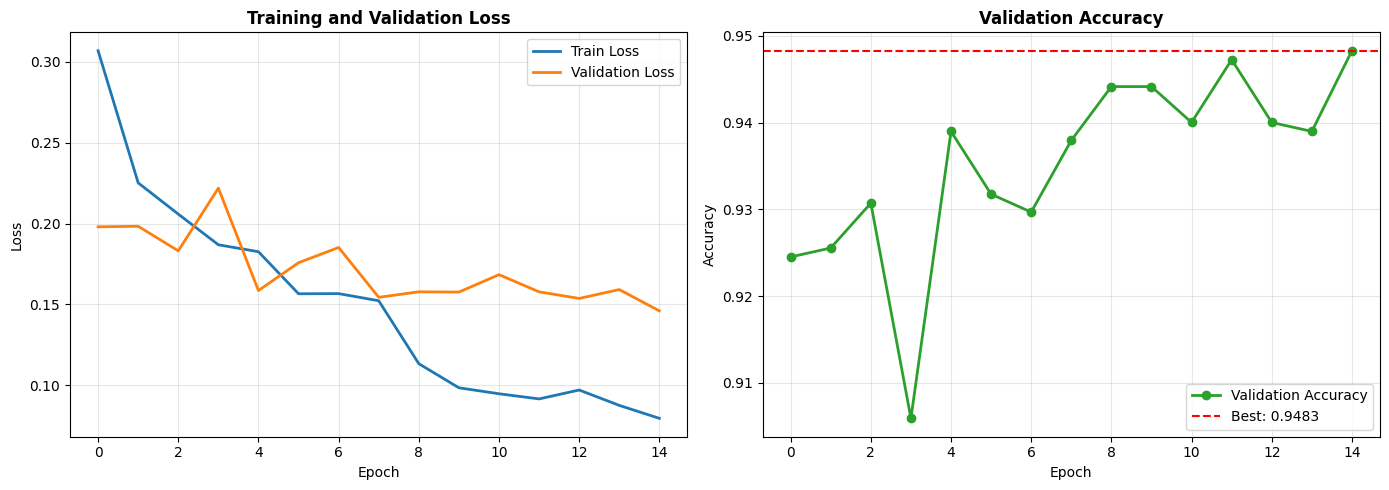

Saved: training_curves.png


In [19]:
# Plot training curves
import matplotlib.pyplot as plt  # Ensure matplotlib is imported
import os
import torch  # Import torch for loading checkpoint

# Load training history if variables don't exist (in case kernel was restarted)
if 'train_losses' not in globals() or 'val_losses' not in globals() or 'val_accuracies' not in globals() or 'best_val_acc' not in globals():
    checkpoint_path = 'best_vangogh_classifier.pth'
    if os.path.exists(checkpoint_path):
        print(f"Loading training history from {checkpoint_path}...")
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])
        val_accuracies = checkpoint.get('val_accuracies', [])
        best_val_acc = checkpoint.get('best_val_acc', 0.0)
        print(f"Loaded training history: {len(train_losses)} epochs, Best Val Acc: {best_val_acc:.4f}")
    else:
        raise NameError(
            f"Training variables not found and checkpoint file '{checkpoint_path}' doesn't exist!\n"
            "   Please run Step 7 (Train Final Model) first before plotting."
        )

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, label='Train Loss', color='#1f77b4', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', color='#ff7f0e', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(val_accuracies, label='Validation Accuracy', color='#2ca02c', linewidth=2, marker='o')
axes[1].axhline(y=best_val_acc, color='r', linestyle='--', label=f'Best: {best_val_acc:.4f}')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150)
plt.show()
print("Saved: training_curves.png")


## 9. Test Set Evaluation


In [20]:
# Evaluate on test set (final performance metric)
import torch
import os

# Load best_params if not available (needed for batch_size)
if 'best_params' not in globals():
    checkpoint_path = 'best_vangogh_classifier.pth'
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        best_params = checkpoint.get('best_params')
        if best_params:
            print(f"Loaded best_params from checkpoint")
    if 'best_params' not in globals() or best_params is None:
        import pickle
        study_save_path = 'optuna_study_results.pkl'
        if os.path.exists(study_save_path):
            with open(study_save_path, 'rb') as f:
                study_data = pickle.load(f)
            best_params = study_data['best_params']
            print(f"Loaded best_params from study file")
        else:
            raise NameError(
                "Cannot find best_params!\n"
                "   Please run Step 6 (Hyperparameter Tuning) or Step 7 (Train Final Model) first."
            )

# Check if trained_classifier exists (step 7 must be run for evaluation)
if 'trained_classifier' not in globals():
    raise NameError(
        "'trained_classifier' not found!\n"
        "   Please run Step 7 (Train Final Model) first before evaluation.\n"
        "   The model needs to be created and trained in step 7."
    )

test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False, num_workers=2)

trained_classifier.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)
        outputs = trained_classifier(images)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())

all_preds, all_labels, all_probs = np.array(all_preds), np.array(all_labels), np.array(all_probs)

# Calculate metrics
test_accuracy = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds)
test_recall = recall_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds)
test_auc = roc_auc_score(all_labels, all_probs)

print("="*60)
print("TEST SET RESULTS")
print("="*60)
print(f"\nMetrics:")
print(f"   Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Precision: {test_precision:.4f}")
print(f"   Recall:    {test_recall:.4f}")
print(f"   F1-Score:  {test_f1:.4f}")
print(f"   AUC-ROC:   {test_auc:.4f}")

print(f"\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Not Van Gogh', 'Van Gogh']))


Evaluating: 100%|██████████| 16/16 [00:22<00:00,  1.39s/it]

TEST SET RESULTS

Metrics:
   Accuracy:  0.9401 (94.01%)
   Precision: 0.8207
   Recall:    0.7881
   F1-Score:  0.8041
   AUC-ROC:   0.9699

Classification Report:
              precision    recall  f1-score   support

Not Van Gogh       0.96      0.97      0.96       817
    Van Gogh       0.82      0.79      0.80       151

    accuracy                           0.94       968
   macro avg       0.89      0.88      0.88       968
weighted avg       0.94      0.94      0.94       968



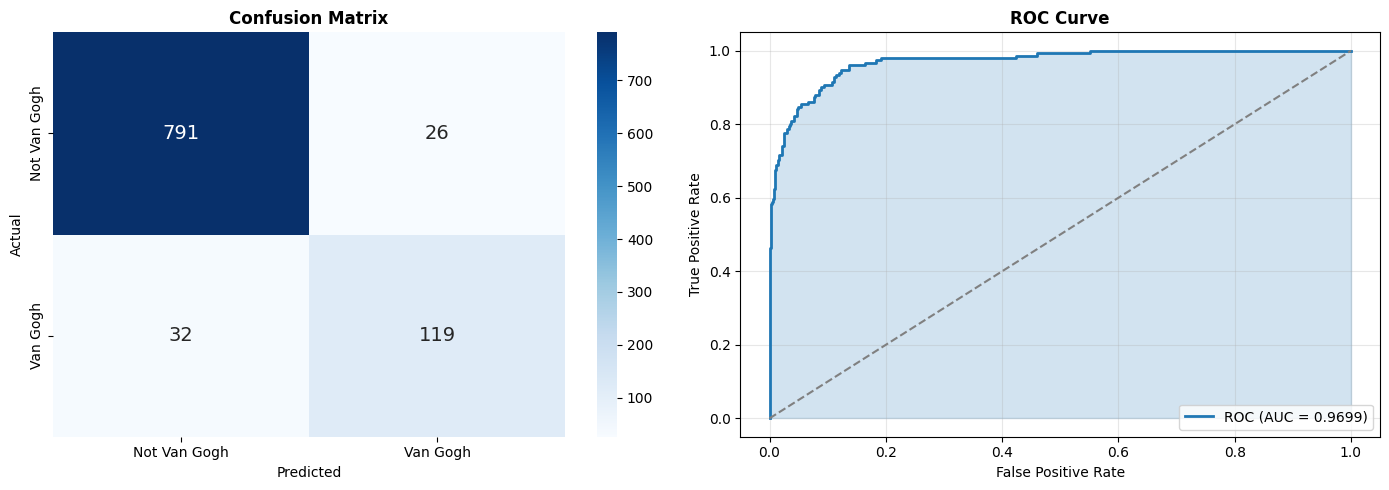

Saved: confusion_matrix_roc.png


In [21]:
# Confusion Matrix and ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Not Van Gogh', 'Van Gogh'],
            yticklabels=['Not Van Gogh', 'Van Gogh'], annot_kws={'size': 14})
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix', fontweight='bold')

fpr, tpr, _ = roc_curve(all_labels, all_probs)
axes[1].plot(fpr, tpr, color='#1f77b4', linewidth=2, label=f'ROC (AUC = {test_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[1].fill_between(fpr, tpr, alpha=0.2, color='#1f77b4')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('confusion_matrix_roc.png', dpi=150)
plt.show()
print("Saved: confusion_matrix_roc.png")


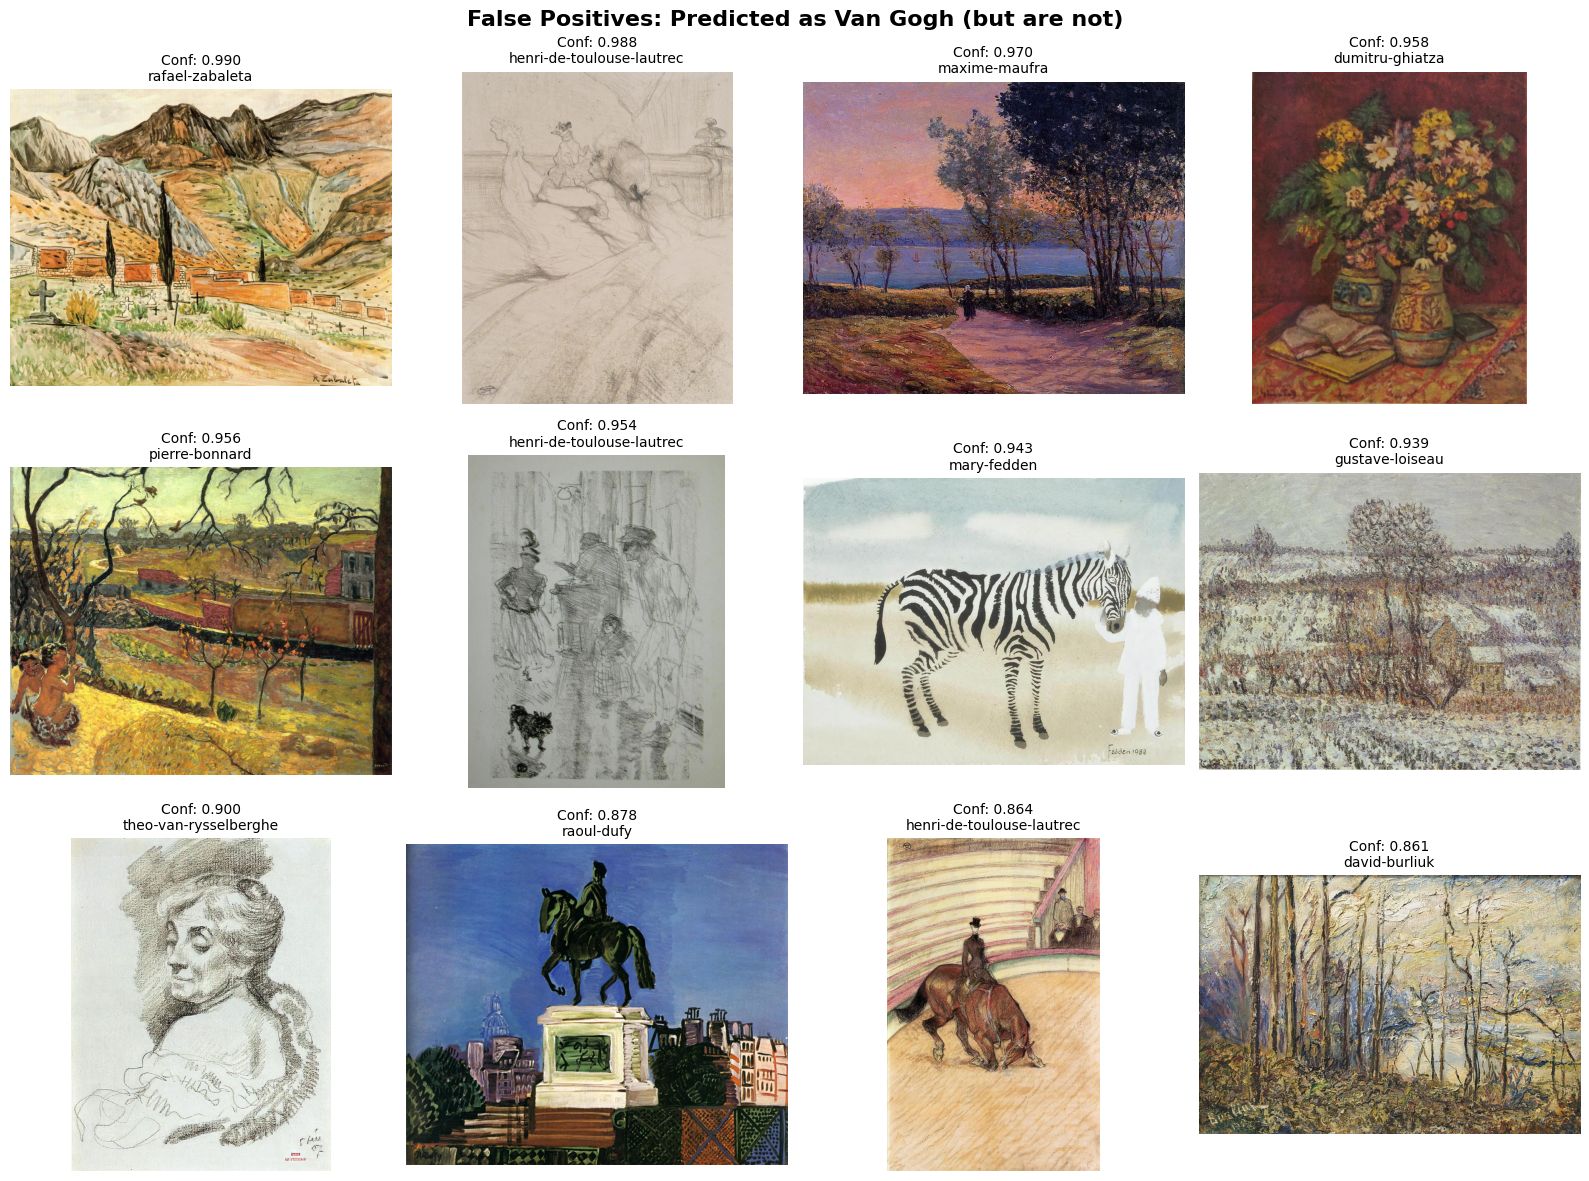

Saved: false_positives.png

Total False Positives: 26 / 968


In [23]:
# Visualize False Positives (images predicted as Van Gogh but are not)
# This is important for analysis in Part 3
import matplotlib.pyplot as plt
from PIL import Image

# Find False Positives
false_positives = []
for idx, (pred, label, prob) in enumerate(zip(all_preds, all_labels, all_probs)):
    if pred == 1 and label == 0:  # Predicted Van Gogh but is not
        false_positives.append((idx, prob))

# Sort by confidence (highest probability first)
false_positives.sort(key=lambda x: x[1], reverse=True)

# Display top False Positives
num_to_show = min(12, len(false_positives))
if num_to_show > 0:
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle('False Positives: Predicted as Van Gogh (but are not)', fontsize=16, fontweight='bold')
    
    for i, (idx, prob) in enumerate(false_positives[:num_to_show]):
        row = i // 4
        col = i % 4
        
        # Get image path from test dataset
        image_path = test_df.iloc[idx]['filepath']
        image = Image.open(image_path)
        
        axes[row, col].imshow(image)
        axes[row, col].set_title(f'Conf: {prob:.3f}\n{test_df.iloc[idx]["artist"]}', fontsize=10)
        axes[row, col].axis('off')
    
    # Hide empty subplots
    for i in range(num_to_show, 12):
        row = i // 4
        col = i % 4
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.savefig('false_positives.png', dpi=150)
    plt.show()
    print(f"Saved: false_positives.png")
    print(f"\nTotal False Positives: {len(false_positives)} / {len(all_preds)}")
else:
    print("No False Positives found!")


## 10. Final Summary


In [24]:
# Final Summary
print("="*60)
print("PART A - VAN GOGH CLASSIFIER - SUMMARY")
print("="*60)

print("\nDataset:")
print(f"   Total: {len(df)} | Van Gogh: {df['is_van_gogh'].sum()} | Other: {len(df)-df['is_van_gogh'].sum()}")
print(f"   Split: 70% train / 15% val / 15% test")

print("\nBest Hyperparameters:")
for k, v in best_params.items():
    print(f"   {k}: {v}")

print("\nPerformance:")
print(f"   Best Val Acc:  {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"   Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Test F1-Score: {test_f1:.4f}")
print(f"   Test AUC-ROC:  {test_auc:.4f}")

print("\nSaved Files:")
print("   best_vangogh_classifier.pth")
print("   training_curves.png")
print("   confusion_matrix_roc.png")

print("\nPart A Complete!")
print("="*60)


PART A - VAN GOGH CLASSIFIER - SUMMARY

Dataset:
   Total: 6450 | Van Gogh: 1005 | Other: 5445
   Split: 70% train / 15% val / 15% test

Best Hyperparameters:
   model_name: AlexNet
   lr: 7.386001288821499e-05
   optimizer: Adam
   batch_size: 64
   weight_decay: 0.0010581858771386648
   freeze_features: False
   dropout: 0.21717283491300782

Performance:
   Best Val Acc:  0.9483 (94.83%)
   Test Accuracy: 0.9401 (94.01%)
   Test F1-Score: 0.8041
   Test AUC-ROC:  0.9699

Saved Files:
   best_vangogh_classifier.pth
   training_curves.png
   confusion_matrix_roc.png

Part A Complete!


# ============================================================
# PART B - NEURAL STYLE TRANSFER
# ============================================================

This section implements style transfer using the trained classifier from Part A.
The `trained_classifier` from Part A will be used as the judge for evaluating style transfer quality.

In [ ]:
# Use the trained model from Part A as judge
# The trained_classifier from Part A is already trained and ready to use

if "trained_classifier" not in globals():
    raise NameError(
        "trained_classifier not found! Please run Part A first.\n"
        "The model needs to be trained in Part A before using it in Part B."
    )

# Use trained_classifier as the judge
judge_model = trained_classifier
judge_model.eval()  # Ensure it's in eval mode
judge_model_name = best_params.get("model_name", "VGG19") if "best_params" in globals() else "VGG19"

print(f"Using {judge_model_name} from Part A as judge for hyperparameter search")
print(f"Model validation accuracy: {best_val_acc:.4f}")


## 4. Part 2A: Style Transfer Function

This section implements the generic style transfer function (from Nir_part_B)


In [ ]:
# Image loading and preprocessing
imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def image_loader(image_path):
    """Load and preprocess an image"""
    image = Image.open(image_path).convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def imshow(tensor, title=None, save_path=None):
    """Display a tensor as an image"""
    image = tensor.cpu().clone().detach().squeeze(0)
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    image = inv_normalize(image)
    image = transforms.ToPILImage()(image.clamp(0, 1))
    
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    
    if save_path:
        image.save(save_path)
    
    plt.show()
    return image


In [ ]:
# Helper function for Gram matrix (used in style loss)
def get_gram_matrix(tensor):
    """Compute Gram matrix for style loss"""
    b, c, h, w = tensor.size()
    features = tensor.view(b * c, h * w)
    gram = torch.mm(features, features.t())
    return gram / (b * c * h * w)


In [ ]:
# Function to extract features from model layers
def get_features(image, model, layers_dict):
    """Extract activation maps from selected layers in the model"""
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers_dict:
            features[layers_dict[name]] = x
    return features


In [ ]:
def neural_style_transfer(style_loss_network, content_image, style_image, 
                          content_layers, style_layers, 
                          content_weight, style_weight, 
                          style_layer_weights, num_steps=300):
    """
    Generic neural style transfer function
    
    Args:
        model: Pre-trained network (VGG-19 or AlexNet features)
        content_image: Image whose structure to preserve
        style_image: Image whose artistic style to apply
        content_layers: Dict mapping layer indices to names for content features
        style_layers: Dict mapping layer indices to names for style features
        content_weight: Scalar (α) to control emphasis on content
        style_weight: Scalar (β) to control intensity of style
        style_layer_weights: Dict of weights to balance each style layer contribution
        num_steps: Number of optimization steps
    
    Returns:
        Final stylized image tensor
    """
    # Set model to eval mode and freeze parameters
    style_loss_network.eval()
    for param in style_loss_network.parameters():
        param.requires_grad = False
    
    # Initialize target image as clone of content image
    target = content_image.clone().requires_grad_(True)
    
    # Combine all layers needed
    all_layers = {**content_layers, **style_layers}
    
    # Extract fixed features from source images
    content_features = get_features(content_image, style_loss_network, content_layers)
    style_features = get_features(style_image, style_loss_network, style_layers)
    
    # Compute Gram matrices for style image
    style_grams = {layer: get_gram_matrix(style_features[layer]) for layer in style_features}

    # Setup optimizer (LBFGS recommended for NST)
    optimizer = optim.LBFGS([target])
    
    # Optimization loop
    for i in range(num_steps):
        def closure():
            optimizer.zero_grad()
            
            # Extract current features from target
            target_features = get_features(target, model, all_layers)
            
            # Compute Content Loss
            c_loss = 0
            for layer in content_layers.values():
                c_loss += torch.mean((target_features[layer] - content_features[layer])**2)
            
            # Compute Style Loss
            s_loss = 0
            for layer in style_layers.values():
                target_gram = get_gram_matrix(target_features[layer])
                style_gram = style_grams[layer]
                layer_weight = style_layer_weights.get(layer, 1.0)
                s_loss += layer_weight * torch.mean((target_gram - style_gram)**2)
            
            # Total weighted loss
            total_loss = content_weight * c_loss + style_weight * s_loss
            total_loss.backward()
            
            return total_loss

        optimizer.step(closure)
        
        # Optional: print progress every 50 steps
        if (i + 1) % 50 == 0:
            print(f"Step {i+1}/{num_steps} completed")
    
    return target.detach()


## 5. Prepare Style and Content Images


In [ ]:
# Find Van Gogh paintings to use as style images
# We need at least 5 different Van Gogh paintings

def find_van_gogh_paintings(base_dir, min_count=5):
    """Find Van Gogh painting files"""
    van_gogh_files = []
    
    # Search for specific famous paintings
    keywords = [
        "starry-night",
        "sunflowers",
        "crows",  # Wheatfield with Crows
        "cafe-terrace",
        "irises",
        "bedroom",
        "almond-blossom",
        "self-portrait"
    ]
    
    for fname in os.listdir(base_dir):
        if not fname.lower().endswith((".jpg", ".png")):
            continue
        
        if "van-gogh" in fname.lower():
            # Check if it matches any keyword
            for keyword in keywords:
                if keyword in fname.lower():
                    filepath = os.path.join(base_dir, fname)
                    if filepath not in van_gogh_files:
                        van_gogh_files.append(filepath)
                    break
    
    # If we don't have enough, add more random Van Gogh paintings
    if len(van_gogh_files) < min_count:
        for fname in os.listdir(base_dir):
            if len(van_gogh_files) >= min_count:
                break
            if not fname.lower().endswith((".jpg", ".png")):
                continue
            if "van-gogh" in fname.lower():
                filepath = os.path.join(base_dir, fname)
                if filepath not in van_gogh_files:
                    van_gogh_files.append(filepath)
    
    return van_gogh_files[:min_count] if len(van_gogh_files) >= min_count else van_gogh_files

# Find base directory
possible_dirs = [
    "/kaggle/input/wikiart/Post_Impressionism",
    "/kaggle/input/Post_Impressionism",
    "/content/data/Post_Impressionism",
    "./Post_Impressionism"
]

base_dir = None
for dir_path in possible_dirs:
    if os.path.exists(dir_path):
        base_dir = dir_path
        break

if base_dir:
    style_image_paths = find_van_gogh_paintings(base_dir, min_count=5)
    print(f"Found {len(style_image_paths)} Van Gogh style images:")
    for i, path in enumerate(style_image_paths, 1):
        print(f"  {i}. {os.path.basename(path)}")
else:
    print("Warning: Could not find Post_Impressionism directory")
    print("Please manually specify style_image_paths below")
    style_image_paths = []


In [ ]:
# Manually specify style images if automatic search didn't work
# Or add your preferred Van Gogh paintings here
if len(style_image_paths) < 5:
    # Example paths (adjust based on your setup)
    style_image_paths = [
        "/kaggle/input/wikiart/Post_Impressionism/vincent-van-gogh_the-starry-night-1889(1).jpg",
        "/kaggle/input/wikiart/Post_Impressionism/vincent-van-gogh_sunflowers-1888.jpg",
        "/kaggle/input/wikiart/Post_Impressionism/vincent-van-gogh_wheatfield-with-crows-1890.jpg",
        "/kaggle/input/wikiart/Post_Impressionism/vincent-van-gogh_cafe-terrace-at-night-1888.jpg",
        "/kaggle/input/wikiart/Post_Impressionism/vincent-van-gogh_irises-1889.jpg"
    ]
    
    # Filter to only existing files
    style_image_paths = [p for p in style_image_paths if os.path.exists(p)]
    print(f"Using {len(style_image_paths)} manually specified style images")


In [ ]:
# Prepare content images
# You should provide 20 content images (personal photos are encouraged!)
# For now, we'll create a placeholder that you can replace

def find_content_images(content_dir=None, count=20):
    """Find content images for style transfer"""
    content_paths = []
    
    # Try to find content images directory
    possible_dirs = [
        "/kaggle/input/content",
        "/kaggle/input/content-images",
        "./content_images",
        content_dir
    ]
    
    content_base = None
    for dir_path in possible_dirs:
        if dir_path and os.path.exists(dir_path):
            content_base = dir_path
            break
    
    if content_base:
        # Load all images from directory
        for fname in os.listdir(content_base):
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                content_paths.append(os.path.join(content_base, fname))
                if len(content_paths) >= count:
                    break
    
    return content_paths

content_image_paths = find_content_images(count=20)

if len(content_image_paths) < 20:
    print(f"Warning: Found only {len(content_image_paths)} content images")
    print("Please add more content images or use images from the dataset")
    
    # Fallback: use some non-Van-Gogh paintings as content images
    if base_dir:
        print("Using non-Van-Gogh paintings as content images...")
        for fname in os.listdir(base_dir):
            if len(content_image_paths) >= 20:
                break
            if not fname.lower().endswith((".jpg", ".png")):
                continue
            if "van-gogh" not in fname.lower():
                content_image_paths.append(os.path.join(base_dir, fname))

print(f"\nPrepared {len(content_image_paths)} content images")


## 6. Define Layer Configurations for VGG-19 and AlexNet


In [ ]:
# VGG-19 layer configuration
VGG19_CONTENT_LAYERS = {'21': 'content'}  # conv4_2

VGG19_STYLE_LAYERS = {
    '0': 'conv1_1',
    '5': 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '28': 'conv5_1'
}

VGG19_STYLE_LAYER_WEIGHTS = {
    'conv1_1': 1.0,
    'conv2_1': 0.8,
    'conv3_1': 0.5,
    'conv4_1': 0.3,
    'conv5_1': 0.1
}

# AlexNet layer configuration (simpler, fewer layers)
ALEXNET_CONTENT_LAYERS = {'8': 'content'}  # conv3

ALEXNET_STYLE_LAYERS = {
    '0': 'conv1',
    '3': 'conv2',
    '6': 'conv3'
}

ALEXNET_STYLE_LAYER_WEIGHTS = {
    'conv1': 1.0,
    'conv2': 0.75,
    'conv3': 0.5
}

print("Layer configurations defined for VGG-19 and AlexNet")


## 7. Part 2B: Hyperparameter Search with Optuna

Find optimal style transfer hyperparameters using the Part 1 classifier as a judge.


In [ ]:
# Login to Weights & Biases
wandb.login(key="16d1bc863b28f81253ac0ee253b453393791a7e1")
print("Logged in to Weights & Biases")


In [ ]:
# Load VGG-19 features model for style transfer
vgg_features = models.vgg19(weights='IMAGENET1K_V1').features.to(device).eval()
for param in vgg_features.parameters():
    param.requires_grad = False
print("VGG-19 features model loaded for style transfer")


In [ ]:
# Select fixed content and style images for hyperparameter search
# Using one content image and one style image for consistency
if len(content_image_paths) > 0 and len(style_image_paths) > 0:
    search_content_path = content_image_paths[0]
    search_style_path = style_image_paths[0]  # Use first Van Gogh painting
    
    search_content_img = image_loader(search_content_path)
    search_style_img = image_loader(search_style_path)
    
    print(f"Using content image: {os.path.basename(search_content_path)}")
    print(f"Using style image: {os.path.basename(search_style_path)}")
    
    # Display the images
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    imshow(search_content_img, "Content Image")
    plt.subplot(1, 2, 2)
    imshow(search_style_img, "Style Image (Van Gogh)")
else:
    raise ValueError("Need at least one content and one style image for hyperparameter search!")


In [ ]:
def style_transfer_objective(trial):
    """
    Optuna objective function for style transfer hyperparameter search.
    Maximizes the classifier's probability that the stylized image is Van Gogh.
    """
    # Suggest hyperparameters
    content_weight = trial.suggest_float("content_weight", 1e-4, 1e2, log=True)
    style_weight = trial.suggest_float("style_weight", 1e3, 1e9, log=True)
    
    # Optional: also search style_layer_weights (can be commented out for faster search)
    # For now, use fixed style_layer_weights to reduce search space
    
    # Run style transfer with suggested parameters
    # Use fewer steps for faster search (can increase for final results)
    num_steps = 100  # Reduced for faster hyperparameter search
    
    try:
        stylized_image = neural_style_transfer(
            vgg_features,
            search_content_img,
            search_style_img,
            VGG19_CONTENT_LAYERS,
            VGG19_STYLE_LAYERS,
            content_weight,
            style_weight,
            VGG19_STYLE_LAYER_WEIGHTS,
            num_steps=num_steps
        )
        
        # Prepare image for classifier (resize to 224x224)
        judge_input = F.interpolate(stylized_image, size=(224, 224), mode='bilinear', align_corners=False)
        
        # Get score from judge (classifier)
        with torch.no_grad():
            output = judge_model(judge_input)
            probabilities = F.softmax(output, dim=1)
            # Assuming class 1 is "Van Gogh" (check your model's class order)
            van_gogh_prob = probabilities[0][1].item()  # Probability of being Van Gogh
        
        return van_gogh_prob
    
    except Exception as e:
        print(f"Error in trial {trial.number}: {e}")
        return 0.0  # Return low score on error

print("Style transfer objective function defined")


In [ ]:
# Run Optuna hyperparameter search
print("="*60)
print("PART 2B: HYPERPARAMETER SEARCH FOR STYLE TRANSFER")
print("="*60)
print("\nObjective: Maximize classifier's Van Gogh probability")
print("This may take 30-60 minutes depending on number of trials...")

# Create study
study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=2)
)

# Initialize wandb run for tracking
wandb_run = wandb.init(
    project="VanGogh_StyleTransfer_HPO",
    name="style_transfer_hyperparameter_search",
    config={"judge_model": judge_model_name}
)

# Track start time
start_time = time.time()

# Run optimization (adjust n_trials and timeout as needed)
# For faster results, use fewer trials; for better results, use more
study.optimize(style_transfer_objective, n_trials=15, timeout=3600, show_progress_bar=True)

elapsed_time = time.time() - start_time
elapsed_minutes = elapsed_time / 60

print("\n" + "="*60)
print("HYPERPARAMETER SEARCH COMPLETE!")
print("="*60)
print(f"\nTime taken: {elapsed_minutes:.2f} minutes ({elapsed_time:.0f} seconds)")
print(f"Completed trials: {len(study.trials)}")
print(f"\nBest Van Gogh probability: {study.best_value:.4f}")
print(f"\nOptimal hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Log best parameters to wandb
wandb.log({"best_van_gogh_prob": study.best_value, **study.best_params})
wandb_run.finish()

# Save results
best_style_transfer_params = study.best_params
with open('best_style_transfer_params.pkl', 'wb') as f:
    pickle.dump(best_style_transfer_params, f)
print("\nSaved optimal parameters to 'best_style_transfer_params.pkl'")


## 8. Part 2C: Application & Evaluation

Apply style transfer to 20 images using both VGG-19 and AlexNet, then evaluate with both classifiers.


In [ ]:
# Load optimal hyperparameters (or use defaults if search wasn't run)
if 'best_style_transfer_params' not in globals():
    if os.path.exists('best_style_transfer_params.pkl'):
        with open('best_style_transfer_params.pkl', 'rb') as f:
            best_style_transfer_params = pickle.load(f)
        print(f"Loaded optimal parameters from file")
    else:
        # Use reasonable defaults if search wasn't run
        best_style_transfer_params = {
            'content_weight': 1e-2,
            'style_weight': 1e6
        }
        print("Using default parameters (hyperparameter search not run)")

print(f"\nUsing hyperparameters:")
for k, v in best_style_transfer_params.items():
    print(f"  {k}: {v}")


In [ ]:
# Load both VGG-19 and AlexNet feature models
vgg19_features = models.vgg19(weights='IMAGENET1K_V1').features.to(device).eval()
for param in vgg19_features.parameters():
    param.requires_grad = False

alexnet_features = models.alexnet(weights='IMAGENET1K_V1').features.to(device).eval()
for param in alexnet_features.parameters():
    param.requires_grad = False

print("Both VGG-19 and AlexNet feature models loaded")


In [ ]:
# Set consistent number of epochs/steps for all style transfers
# This must be the same for all images and models (project requirement)
CONSISTENT_NUM_STEPS = 300  # You can adjust this, but keep it consistent

print(f"Using {CONSISTENT_NUM_STEPS} optimization steps for all style transfers")


In [ ]:
# Function to apply style transfer and evaluate
def apply_and_evaluate_style_transfer(content_path, style_path, model_name='VGG19', 
                                     save_dir='/kaggle/working/stylized_images'):
    """
    Apply style transfer and evaluate with both classifiers
    
    Returns:
        dict with stylized image, evaluation scores, and metadata
    """
    # Load images
    content_img = image_loader(content_path)
    style_img = image_loader(style_path)
    
    # Select model and layer configuration
    if model_name == 'VGG19':
        style_loss_network = vgg19_features
        content_layers = VGG19_CONTENT_LAYERS
        style_layers = VGG19_STYLE_LAYERS
        style_layer_weights = VGG19_STYLE_LAYER_WEIGHTS
    elif model_name == 'AlexNet':
        style_loss_network = alexnet_features
        content_layers = ALEXNET_CONTENT_LAYERS
        style_layers = ALEXNET_STYLE_LAYERS
        style_layer_weights = ALEXNET_STYLE_LAYER_WEIGHTS
    else:
        raise ValueError(f"Unknown model: {model_name}")
    
    # Apply style transfer
    print(f"\nApplying {model_name} style transfer...")
    stylized = neural_style_transfer(
        style_loss_network, content_img, style_img,
        content_layers, style_layers,
        best_style_transfer_params['content_weight'],
        best_style_transfer_params['style_weight'],
        style_layer_weights,
        num_steps=CONSISTENT_NUM_STEPS
    )
    
    # Prepare for classifier evaluation
    eval_input = F.interpolate(stylized, size=(224, 224), mode='bilinear', align_corners=False)
    
    # Evaluate with judge_model (and potentially other classifiers)
    with torch.no_grad():
        output = judge_model(eval_input)
        probs = F.softmax(output, dim=1)
        judge_van_gogh_prob = probs[0][1].item()
        judge_prediction = output.argmax(dim=1).item()
    
    # Save stylized image
    os.makedirs(save_dir, exist_ok=True)
    content_name = os.path.splitext(os.path.basename(content_path))[0]
    style_name = os.path.splitext(os.path.basename(style_path))[0]
    save_path = os.path.join(save_dir, f"{model_name}_{content_name}_{style_name}.jpg")
    
    # Convert and save
    result_image = imshow(stylized, f"{model_name}: {os.path.basename(content_path)}", save_path=save_path)
    
    return {
        'stylized_image': stylized,
        'content_path': content_path,
        'style_path': style_path,
        'model_name': model_name,
        'judge_van_gogh_prob': judge_van_gogh_prob,
        'judge_prediction': judge_prediction,
        'save_path': save_path
    }

print("Style transfer application function defined")


In [ ]:
# Apply style transfer to 20 images with both VGG-19 and AlexNet
# Use at least 5 different Van Gogh paintings as style images

print("="*60)
print("PART 2C: APPLYING STYLE TRANSFER TO 20 IMAGES")
print("="*60)

# Ensure we have enough content and style images
num_content = min(20, len(content_image_paths))
num_styles = min(5, len(style_image_paths))

print(f"\nProcessing {num_content} content images with {num_styles} style images")
print(f"Using {CONSISTENT_NUM_STEPS} steps for all transfers")

# Store all results
all_results = []

# Process each content image with each style image, using both models
content_to_process = content_image_paths[:num_content]
styles_to_use = style_image_paths[:num_styles]

# Distribute style images across content images
# Each content image gets styled with different Van Gogh paintings
for i, content_path in enumerate(tqdm(content_to_process, desc="Processing content images")):
    # Cycle through style images
    style_idx = i % num_styles
    style_path = styles_to_use[style_idx]
    
    # Apply with VGG-19
    try:
        vgg_result = apply_and_evaluate_style_transfer(
            content_path, style_path, model_name='VGG19'
        )
        all_results.append(vgg_result)
    except Exception as e:
        print(f"Error with VGG-19 on {content_path}: {e}")
    
    # Apply with AlexNet
    try:
        alexnet_result = apply_and_evaluate_style_transfer(
            content_path, style_path, model_name='AlexNet'
        )
        all_results.append(alexnet_result)
    except Exception as e:
        print(f"Error with AlexNet on {content_path}: {e}")

print(f"\nCompleted {len(all_results)} style transfers")


In [ ]:
# Evaluate results with judge_model (trained_classifier from Part A)
# We use the same judge_model for all evaluations

def evaluate_with_classifier(stylized_image, classifier, classifier_name):
    """Evaluate a stylized image with a classifier"""
    eval_input = F.interpolate(stylized_image, size=(224, 224), mode='bilinear', align_corners=False)
    
    with torch.no_grad():
        output = classifier(eval_input)
        probs = F.softmax(output, dim=1)
        van_gogh_prob = probs[0][1].item()
        prediction = output.argmax(dim=1).item()
    
    return {
        f'{classifier_name}_van_gogh_prob': van_gogh_prob,
        f'{classifier_name}_prediction': prediction
    }

# Use judge_model (trained_classifier from Part A) for all evaluations
print("\nEvaluating all stylized images with judge_model (trained_classifier from Part A)...")

for result in tqdm(all_results, desc="Evaluating"):
    stylized = result['stylized_image']
    
    # Evaluate with judge model (already done, but add to results)
    result['judge_eval'] = {
        'van_gogh_prob': result['judge_van_gogh_prob'],
        'prediction': result['judge_prediction']
    }
    
    # All evaluations use the same judge_model (trained_classifier from Part A)
    # This is the trained classifier from Part A

print("\nEvaluation complete!")


In [ ]:
# Analyze and summarize results
print("="*60)
print("PART 2C: RESULTS SUMMARY")
print("="*60)

# Convert results to DataFrame for analysis
results_df = pd.DataFrame([
    {
        'content': os.path.basename(r['content_path']),
        'style': os.path.basename(r['style_path']),
        'model': r['model_name'],
        'judge_van_gogh_prob': r['judge_van_gogh_prob'],
        'judge_prediction': r['judge_prediction']
    }
    for r in all_results
])

# Add classifier evaluations if available
for r in all_results:
    if 'VGG19_classifier_van_gogh_prob' in r:
        idx = results_df[results_df['content'] == os.path.basename(r['content_path'])].index[0]
        results_df.loc[idx, 'VGG19_classifier_van_gogh_prob'] = r.get('VGG19_classifier_van_gogh_prob', None)
    if 'AlexNet_classifier_van_gogh_prob' in r:
        idx = results_df[results_df['content'] == os.path.basename(r['content_path'])].index[0]
        results_df.loc[idx, 'AlexNet_classifier_van_gogh_prob'] = r.get('AlexNet_classifier_van_gogh_prob', None)

print("\nResults Summary:")
print(results_df.head(10))

# Statistics by model
print("\n" + "="*60)
print("STATISTICS BY STYLE TRANSFER MODEL")
print("="*60)

for model in ['VGG19', 'AlexNet']:
    model_results = results_df[results_df['model'] == model]
    if len(model_results) > 0:
        print(f"\n{model} Style Transfer:")
        print(f"  Number of images: {len(model_results)}")
        print(f"  Mean Van Gogh probability (Judge): {model_results['judge_van_gogh_prob'].mean():.4f}")
        print(f"  Std Van Gogh probability (Judge): {model_results['judge_van_gogh_prob'].std():.4f}")
        print(f"  Predicted as Van Gogh: {model_results['judge_prediction'].sum()}/{len(model_results)}")
        
        if 'VGG19_classifier_van_gogh_prob' in model_results.columns:
            vgg_probs = model_results['VGG19_classifier_van_gogh_prob'].dropna()
            if len(vgg_probs) > 0:
                print(f"  Mean Van Gogh probability (VGG-19 Classifier): {vgg_probs.mean():.4f}")
        
        if 'AlexNet_classifier_van_gogh_prob' in model_results.columns:
            alexnet_probs = model_results['AlexNet_classifier_van_gogh_prob'].dropna()
            if len(alexnet_probs) > 0:
                print(f"  Mean Van Gogh probability (AlexNet Classifier): {alexnet_probs.mean():.4f}")

# Comparison between VGG-19 and AlexNet
print("\n" + "="*60)
print("VGG-19 vs ALEXNET COMPARISON")
print("="*60)

vgg19_mean = results_df[results_df['model'] == 'VGG19']['judge_van_gogh_prob'].mean()
alexnet_mean = results_df[results_df['model'] == 'AlexNet']['judge_van_gogh_prob'].mean()

print(f"\nVGG-19 mean Van Gogh probability: {vgg19_mean:.4f}")
print(f"AlexNet mean Van Gogh probability: {alexnet_mean:.4f}")
print(f"Difference: {abs(vgg19_mean - alexnet_mean):.4f}")

if vgg19_mean > alexnet_mean:
    print("\nVGG-19 produces more 'Van Gogh-like' results according to the classifier")
else:
    print("\nAlexNet produces more 'Van Gogh-like' results according to the classifier")

# Save results
results_df.to_csv('/kaggle/working/style_transfer_results.csv', index=False)
print("\nResults saved to 'style_transfer_results.csv'")


In [ ]:
# Visualize some example results
print("\n" + "="*60)
print("EXAMPLE STYLIZED IMAGES")
print("="*60)

# Show top 6 results by Van Gogh probability
top_results = sorted(all_results, key=lambda x: x['judge_van_gogh_prob'], reverse=True)[:6]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Top 6 Stylized Images (by Van Gogh Probability)', fontsize=16, fontweight='bold')

for idx, result in enumerate(top_results):
    row = idx // 3
    col = idx % 3
    
    # Display image
    image = result['stylized_image'].cpu().clone().detach().squeeze(0)
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    image = inv_normalize(image)
    image = transforms.ToPILImage()(image.clamp(0, 1))
    
    axes[row, col].imshow(image)
    title = f"{result['model_name']}\nProb: {result['judge_van_gogh_prob']:.3f}"
    axes[row, col].set_title(title, fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout()
plt.savefig('/kaggle/working/top_stylized_images.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: top_stylized_images.png")


In [ ]:
# Final summary
print("="*60)
print("PART B - FINAL SUMMARY")
print("="*60)

print("\nPart 2B: Hyperparameter Search")
print(f"  Optimal content_weight: {best_style_transfer_params.get('content_weight', 'N/A')}")
print(f"  Optimal style_weight: {best_style_transfer_params.get('style_weight', 'N/A')}")
if 'study' in globals():
    print(f"  Best Van Gogh probability achieved: {study.best_value:.4f}")

print("\nPart 2C: Application & Evaluation")
if 'all_results' in globals():
    print(f"  Total style transfers completed: {len(all_results)}")
if 'num_content' in globals():
    print(f"  Content images used: {num_content}")
if 'num_styles' in globals():
    print(f"  Style images used: {num_styles}")
if 'CONSISTENT_NUM_STEPS' in globals():
    print(f"  Optimization steps per image: {CONSISTENT_NUM_STEPS}")

print("\nModel Comparison:")
if 'vgg19_mean' in globals() and 'alexnet_mean' in globals():
    print(f"  VGG-19 mean probability: {vgg19_mean:.4f}")
    print(f"  AlexNet mean probability: {alexnet_mean:.4f}")
else:
    print("  Run results analysis cell to see comparison")

print("\nSaved Files:")
print("  - best_style_transfer_params.pkl")
print("  - style_transfer_results.csv")
print("  - top_stylized_images.png")
print("  - stylized_images/ (directory with all stylized images)")

print("\nPart B Complete!")
print("="*60)


In [ ]:
# ============================================================
# INTEGRATION: Classify Final Stylized Image with Trained Classifier
# ============================================================

# Get the final stylized image from Part B (use the last result)
if "all_results" in globals() and len(all_results) > 0:
    # Get the last stylized image (or you can select a specific one)
    final_stylized_image = all_results[-1]['stylized_image']
    
    print("Classifying final stylized image with trained_classifier from Part A...")
    print("="*60)
    
    # Preprocess the stylized image for the classifier
    # Resize to (224, 224) and normalize with ImageNet stats
    classifier_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    # The image is already a tensor, so we need to handle it differently
    # Convert from (1, 3, H, W) format, resize, then normalize
    import torch.nn.functional as F
    
    # Resize to 224x224
    preprocessed_image = F.interpolate(
        final_stylized_image,
        size=(224, 224),
        mode='bilinear',
        align_corners=False
    )
    
    # Normalize (the image should already be normalized from style transfer, but ensure it matches classifier input)
    # ImageNet normalization
    IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
    IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    
    # Denormalize first (in case it was normalized), then re-normalize
    # Check if it needs normalization - style transfer output should be in [0,1] range
    # We need to normalize it for the classifier
    # First, ensure it is in [0,1] range, then apply ImageNet normalization
    
    # Denormalize from style transfer normalization (if applied)
    # Style transfer uses ImageNet normalization, so we reverse it first
    style_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
    style_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    
    # Reverse normalization: (x * std) + mean
    denormalized = preprocessed_image * style_std + style_mean
    
    # Clamp to [0, 1] range
    denormalized = torch.clamp(denormalized, 0, 1)
    
    # Now normalize for classifier: (x - mean) / std
    classifier_input = (denormalized - IMAGENET_MEAN) / IMAGENET_STD
    
    # Set classifier to eval mode
    trained_classifier.eval()
    
    # Classify the image
    with torch.no_grad():
        output = trained_classifier(classifier_input)
        probabilities = F.softmax(output, dim=1)
        van_gogh_prob = probabilities[0][1].item()  # Probability of being Van Gogh (class 1)
        not_van_gogh_prob = probabilities[0][0].item()  # Probability of not being Van Gogh (class 0)
        prediction = output.argmax(dim=1).item()
    
    print(f"\nClassification Results:")
    print(f"  Probability of being Van Gogh: {van_gogh_prob:.4f} ({van_gogh_prob*100:.2f}%)")
    print(f"  Probability of NOT being Van Gogh: {not_van_gogh_prob:.4f} ({not_van_gogh_prob*100:.2f}%)")
    print(f"  Prediction: {'Van Gogh' if prediction == 1 else 'Not Van Gogh'}")
    print("="*60)
else:
    print("No stylized images found. Please run Part B style transfer first.")
